In [3]:
from os import listdir,mkdir
from os.path import isfile, join, isdir,exists
import pandas as pd
import numpy as np
from scipy import stats
import re
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from myplots import roundup, rounddown, find_decimal_fold, percentile_cut_off, rarefaction_calc, rarefaction_plot,draw_correlation_scatter
from matplotlib.ticker import FormatStrFormatter
import cPickle as pickle
from Bio.SeqUtils import GC
import seaborn as sns
import random
from scipy.stats import pearsonr
from skbio.diversity.alpha import shannon, simpson, berger_parker_d

from pop_organize import get_sample_data, get_sample_with_dfs
from SufficientStatistics import *
from MyFunctionsShani import *
import math
from myplots import roundup, rounddown, find_decimal_fold
from skbio.stats.distance import mantel
from scipy.spatial.distance import braycurtis, pdist
from Feature_phenotype_functions import common_processing_feature_phenotype_matrices, editSampleNames,process_sample_matrix,compute_distance_matrix_general


done1


In [4]:
import time
cdate=str(time.strftime("%d%m%Y"))
cdate

'01022018'

# plot distMat matrices:

In [ ]:
distMatNameList=['1Binary_euclidean','10_euclidean','50_euclidean',
                '1RA_braycurtis','10RA_braycurtis','50RA_braycurtis']


fig, axes = plt.subplots(ncols=3,nrows=2,figsize=(12,6))

for n, distMatName in enumerate(distMatNameList):
    distMatFile='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Distance Matrices/Features/distMat_PNP434_sharingMatrixMoreThan%s' %distMatName  
    distMat=pd.read_pickle(distMatFile)
    
    
    
    if 'RA' in distMatName:
        vmin=np.percentile(distMat.values,1)
        vmax=1
    else:
        vmin=np.percentile(distMat.values,1)
        vmax=np.percentile(distMat.values,99)
    
    Mean=np.mean(distMat.values)
    
    print n, distMatName
    ax=axes.flat[n]
    distMat=process_sample_matrix(distMat,removeSameUser=False,orderMethod='sum')
    f=ax.imshow(distMat,cmap='PiYG',vmin=vmin,vmax=vmax)
    ax.set_title(distMatName)
    ax.annotate('1perc=%s\n99perc=%s\nmean=%s' %(round(vmin,3),round(vmax,3),round(Mean,3)), xy=(0.02, 0.95), xycoords='axes fraction', 
                horizontalalignment='left', verticalalignment='top')

    #interpolation=None, vmin=0, vmax=0.01, cmap='PuRd'
#     plt.colorbar(f,ax)

fig.subplots_adjust(wspace=0.1,hspace=0.28)
# left=0.09, right=0.98, top=0.95, bottom=0.02, 
plt.show()

# calculate number of common sequences per sample pairs

In [ ]:
nShared_cutoff=50
matrix_file='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/PublicSeqAnalysis/sharingMatrix_moreThan%s_434Samples' %nShared_cutoff
matrix_df=pd.read_pickle(matrix_file)

In [ ]:
matrix_df.head()

In [ ]:
def count_common_seqs(sharedMat,nCutOff):
#     from Feature_phenotype_functions import common_processing_feature_phenotype_matrices, editSampleNames,process_sample_matrix
    
    nSamples=len(sharedMat.index)
    sharedMat=editSampleNames(sharedMat)

    commonSeqsCountDF=pd.DataFrame()
    count=0
    for i in range(nSamples):
#             if i%10==0:
#                 print i
            for j in range(i+1,nSamples):
                print i,j
                df=sharedMat.iloc[[i,j],:]
                dfSum=df.sum(axis=0)

                sample1=sharedMat.index[i]
                sample2=sharedMat.index[j]

                if 2 in dfSum.value_counts():
                    nCommonSeqs=dfSum.value_counts()[2]
                else:
                    nCommonSeqs=0
                commonSeqsCountDF.loc[count,'sample1']=sample1
                commonSeqsCountDF.loc[count,'sample2']=sample2
                commonSeqsCountDF.loc[count,'nCommonSeqs']=nCommonSeqs
                count=count+1
    commonSeqsCountDF=commonSeqsCountDF.sort_values(by='nCommonSeqs')
    
    file1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Distance Matrices/commonSeqsCountDFs/commonSeqsCount_%s' %nCutOff
    commonSeqsCountDF.to_pickle(file1)
    
    return commonSeqsCountDF

In [ ]:
# nCutOffList=[50,10,1]
nCutOffList=[10,1]
for n, nCutOff in enumerate(nCutOffList):
    sharedMatFile='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/PublicSeqAnalysis/sharingMatrix_moreThan%s_434Samples' %nCutOff
    sharedMat=pd.read_pickle(sharedMatFile)
    
    print n, nCutOff
    count_common_seqs(sharedMat,nCutOff)

## view histograms of common seq numbers

### load common seq count:

In [ ]:
nCutOff=10
file1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Distance Matrices/commonSeqsCountDFs/commonSeqsCount_%s' %nCutOff
commonSeqsCountDF=pd.read_pickle(file1)
commonSeqsCountDF.head()

### plot number of common sequences:

In [ ]:
fig, axes = plt.subplots(ncols=1,nrows=3,figsize=(10,10))
nCutOffList=[1,10,50]
for n,nCutOff in enumerate(nCutOffList):

    file1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Distance Matrices/commonSeqsCountDFs/commonSeqsCount_%s' %nCutOff
    commonSeqsCountDF=pd.read_pickle(file1)
    print commonSeqsCountDF.tail()

    
    ax=axes.flat[n]

    f=ax.hist(commonSeqsCountDF['nCommonSeqs'],bins=100)
    noComSeqPairs=len(commonSeqsCountDF[commonSeqsCountDF['nCommonSeqs']==0])
    lessThan5ComPairs=len(commonSeqsCountDF[commonSeqsCountDF['nCommonSeqs']<5])
    total=len(commonSeqsCountDF)
    ax.set_title('nCutOff=%s' %nCutOff)
    ax.annotate('no common seqs=%s\nless than 5 common seqs=%s\ntotal pairs=%s' %(noComSeqPairs,lessThan5ComPairs,
                    total), xy=(0.02, 0.95), xycoords='axes fraction', 
                horizontalalignment='left', verticalalignment='top')

# fig.subplots_adjust(wspace=0.1,hspace=0.28)
# left=0.09, right=0.98, top=0.95, bottom=0.02, 
plt.show()

# generate dfs with nCon/nonCOM sequences and distances per sample pair

In [ ]:
from MyFunctionsShani import plot_bestFitLine

In [76]:
def gen_comSeqs_withDistances(nCutOff):
    
    print 'generating comSeqs_withDistances DF...'
    file1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Distance Matrices/commonSeqsCountDFs/commonSeqsCount_%s' %nCutOff
    commonSeqsCountDF=pd.read_pickle(file1)
   
    distMatNameList=['_euclidean','RA_braycurtis','_jaccard','1PCsUsed_euclidean']
    
    for n,distMatName in enumerate(distMatNameList):
        file1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Distance Matrices/samplePairOrderByDistance/distOrder_%s%s' %(nCutOff,distMatName)
        distanceVector=pd.read_pickle(file1)

#         file3='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Distance Matrices/samplePairOrderByDistance/distOrder_%s' %distMatName_bc
#         distanceVector_bc=pd.read_pickle(file3)

#         file4='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Distance Matrices/samplePairOrderByDistance/distOrder_%s' %distMatName_jaccard
#         distanceVector_jaccard=pd.read_pickle(file4)

#         file5='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Distance Matrices/samplePairOrderByDistance/distOrder_%s' %distMatName_PC
#         distanceVector_PC=pd.read_pickle(file5)
        if n==0:
            ComSeqsAllDist=pd.merge(commonSeqsCountDF,distanceVector,how='inner',left_on=('sample1','sample2'),
                               right_on=('sample1','sample2'))
            ComSeqsAllDist=ComSeqsAllDist.rename(columns={'distance':distMatName})
        else:
            ComSeqsAllDist=pd.merge(ComSeqsAllDist,distanceVector,how='inner',left_on=('sample1','sample2'),
                               right_on=('sample1','sample2'))
            ComSeqsAllDist=ComSeqsAllDist.rename(columns={'distance':distMatName})
        
        for column in ComSeqsAllDist:
            ComSeqsAllDist.rename(columns={column:column.replace('_','')})
    return ComSeqsAllDist
    

In [77]:
def gen_nonComSeqs_withDistances(nCutOff):
    
    print 'generating comSeqs_withDistances DF...'
    file1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Distance Matrices/commonSeqsCountDFs/NonCommonSeqsCount_%s' %nCutOff
    nonCommonSeqsCountDF=pd.read_pickle(file1)

    distMatName_euc='%s_euclidean' %nCutOff
    distMatName_bc='%sRA_braycurtis' %nCutOff
    file2='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Distance Matrices/samplePairOrderByDistance/distOrder_%s' %distMatName_euc
    distanceVector_euc=pd.read_pickle(file2)

    file3='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Distance Matrices/samplePairOrderByDistance/distOrder_%s' %distMatName_bc
    distanceVector_bc=pd.read_pickle(file3)

    nonComSeqsEucDist=pd.merge(nonCommonSeqsCountDF,distanceVector_euc,how='inner',left_on=('sample1','sample2'),
                           right_on=('sample1','sample2'))

    nonComSeqsEucDistBCDist=pd.merge(nonComSeqsEucDist,distanceVector_bc,how='inner',left_on=('sample1','sample2'),
                           right_on=('sample1','sample2'))
    
    return nonComSeqsEucDistBCDist
    

In [73]:
ComSeqsAllDist=gen_comSeqs_withDistances(10)
ComSeqsAllDist.head()

generating comSeqs_withDistances DF...


,sample1,sample2,nCommonSeqs,_euclidean,RA_braycurtis,_jaccard,1PCsUsed_euclidean
0,BD484,BD328,0.0,23.643181,1.000000,1.000000,0.006300
1,BD322,BD328,1.0,23.430749,0.998905,0.998182,0.008650
2,BD453,BD481,2.0,23.622024,0.996245,0.996429,0.006136
3,BD831,BD328,2.0,20.396078,0.997855,0.995215,0.005306
4,BD521,BD319,3.0,24.310492,0.990314,0.994949,0.008869


In [48]:
nonComSeqsEucDistBCDist=gen_nonComSeqs_withDistances(10)
nonComSeqsEucDistBCDist.head()

generating comSeqs_withDistances DF...


,sample1,sample2,NonCommonSeqs,distance_x,distance_y
0,BD484,BD328,0.0,23.643181,1.000000
1,BD319,BD328,305.0,17.464249,0.981976
2,BD453,BD328,376.0,19.390719,0.994709
3,BD537,BD328,390.0,19.748418,0.992187
4,BD453,BD319,415.0,20.371549,0.988037


In [ ]:
fig, axes = plt.subplots(ncols=3,nrows=1,figsize=(18,5))
nCutOffList=[1,10,50]
for n,nCutOff in enumerate(nCutOffList):
    print n,nCutOff
    ComSeqsEucDistBCDist=gen_comSeqs_withDistances(nCutOff)

    
    ax=axes.flat[n]
    x=ComSeqsEucDistBCDist['nCommonSeqs']
    y1=ComSeqsEucDistBCDist['distance_x']
    y2=ComSeqsEucDistBCDist['distance_y']
    
    r_euc,p_euc=MyPearsonr(x,y1) 
    r_bc,p_bc=MyPearsonr(x,y2)

    f=ax.scatter([x,x],[y1,y2],color=['b','r'],alpha=0.1,label=['Euc','bc'])
    ax.set_title('Correlation between nComSeqs and distance\nnCutOff=%s' %nCutOff)
    ax.legend()
    plot_bestFitLine(x,y1,ax,color='b')
    plot_bestFitLine(x,y2,ax,color='r')
    ax.annotate('Euc dist:r=%s,p=%s\nBC dist:r=%s,p=%s' %(round(r_euc,2),round(p_euc,3),round(r_bc,2),
                round(p_bc,3)), xy=(0.02, 0.97), xycoords='axes fraction', 
                horizontalalignment='left', verticalalignment='top')

# fig.subplots_adjust(wspace=0.1,hspace=0.28)
# left=0.09, right=0.98, top=0.95, bottom=0.02, 
plt.show()

# plot everything together:

plotting euc distMat matrix:...
original df shape is 434_434
ordering matrix by row and column sums...
new df shape is 434_434
plotting bc distMat matrix:...
0.968498891877 1
original df shape is 434_434
ordering matrix by row and column sums...
new df shape is 434_434
generating comSeqs_withDistances DF...
plotting euc distMat matrix:...
original df shape is 434_434
ordering matrix by row and column sums...
new df shape is 434_434
plotting bc distMat matrix:...
0.905280909667 1
original df shape is 434_434
ordering matrix by row and column sums...
new df shape is 434_434
generating comSeqs_withDistances DF...
plotting euc distMat matrix:...
original df shape is 434_434
ordering matrix by row and column sums...
new df shape is 434_434
plotting bc distMat matrix:...
0.762139485609 1
original df shape is 434_434
ordering matrix by row and column sums...
new df shape is 434_434
generating comSeqs_withDistances DF...


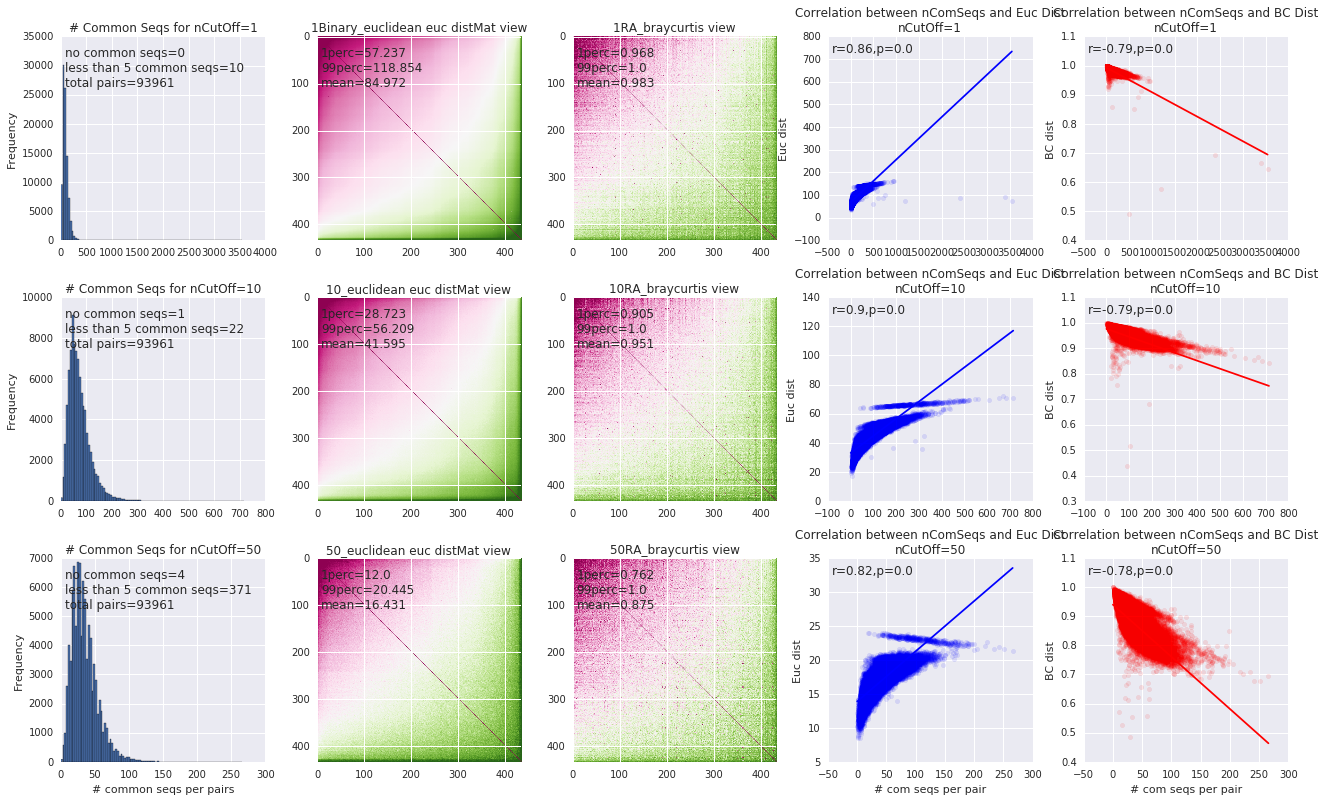

In [13]:
fig, axes = plt.subplots(ncols=5,nrows=3,figsize=(22,13),sharex=False, sharey=False)
nCutOffList=[1,10,50]
for n,nCutOff in enumerate(nCutOffList):
    
    #(1)plot number of common sequences
    
    file1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Distance Matrices/commonSeqsCountDFs/commonSeqsCount_%s' %nCutOff
    commonSeqsCountDF=pd.read_pickle(file1)
#     print commonSeqsCountDF.tail()

    
    ax=axes[n,0]

    f=ax.hist(commonSeqsCountDF['nCommonSeqs'],bins=100)
    noComSeqPairs=len(commonSeqsCountDF[commonSeqsCountDF['nCommonSeqs']==0])
    lessThan5ComPairs=len(commonSeqsCountDF[commonSeqsCountDF['nCommonSeqs']<5])
    total=len(commonSeqsCountDF)
    ax.set_title('# Common Seqs for nCutOff=%s' %nCutOff)
    ax.annotate('no common seqs=%s\nless than 5 common seqs=%s\ntotal pairs=%s' %(noComSeqPairs,lessThan5ComPairs,
                    total), xy=(0.02, 0.95), xycoords='axes fraction', 
                horizontalalignment='left', verticalalignment='top')
    if n==2:
        ax.set_xlabel('# common seqs per pairs')
    ax.set_ylabel('Frequency')
    
    #(2)plot distMat matrices:
    
    #2.a plot euc distMat matrices:
    print 'plotting euc distMat matrix:...'
    distMatEucList=['1Binary_euclidean','10_euclidean','50_euclidean']
    distMatEucFile='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Distance Matrices/Features/distMat_PNP434_sharingMatrixMoreThan%s' %distMatEucList[n]  
    distMatEuc=pd.read_pickle(distMatEucFile)    
    
    vmin=np.percentile(distMatEuc.values,1)
    vmax=np.percentile(distMatEuc.values,99)
    Mean=np.mean(distMatEuc.values)
    
#     print n, distMatName
    ax=axes[n,1]
    distMatEuc=process_sample_matrix(distMatEuc,removeSameUser=False,orderMethod='sum')
    f=ax.imshow(distMatEuc,cmap='PiYG',vmin=vmin,vmax=vmax)
    ax.set_title('%s euc distMat view' %distMatEucList[n])
    ax.annotate('1perc=%s\n99perc=%s\nmean=%s' %(round(vmin,3),round(vmax,3),round(Mean,3)), xy=(0.02, 0.95), xycoords='axes fraction', 
                horizontalalignment='left', verticalalignment='top')
    
    #2.b plot euc distMat matrices:
    print 'plotting bc distMat matrix:...'
    distMatBCList=['1RA_braycurtis','10RA_braycurtis','50RA_braycurtis']
    distMatBCFile='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Distance Matrices/Features/distMat_PNP434_sharingMatrixMoreThan%s' %distMatBCList[n]  
    distMatBC=pd.read_pickle(distMatBCFile)    
    
    vmin=np.percentile(distMatBC.values,1)
    vmax=1
    print vmin, vmax
    Mean=np.mean(distMatBC.values)
    
#     print n, distMatName
    ax=axes[n,2]
    distMatBC=process_sample_matrix(distMatBC,removeSameUser=False,orderMethod='sum')
    f=ax.imshow(distMatBC,cmap='PiYG',vmin=vmin,vmax=vmax)
    ax.set_title('%s view' %distMatBCList[n])
    ax.annotate('1perc=%s\n99perc=%s\nmean=%s' %(round(vmin,3),round(vmax,3),round(Mean,3)), xy=(0.02, 0.95), xycoords='axes fraction', 
                horizontalalignment='left', verticalalignment='top')
    
    
    #(3) plot correlations between n common samples with distances:
    ComSeqsEucDistBCDist=gen_comSeqs_withDistances(nCutOff)
    
    ##3.1 plot correlations between nComSeqs and euc distances:
    ax=axes[n,3]
    x=ComSeqsEucDistBCDist['nCommonSeqs']
    y1=ComSeqsEucDistBCDist['distance_x']
        
    r_euc,p_euc=MyPearsonr(x,y1)

    f=ax.scatter(x,y1,color='b',alpha=0.1)
    ax.set_title('Correlation between nComSeqs and Euc Dist\nnCutOff=%s' %nCutOff)
    plot_bestFitLine(x,y1,ax,color='b')
    ax.annotate('r=%s,p=%s' %(round(r_euc,2),round(p_euc,3)),xy=(0.02, 0.97), xycoords='axes fraction', 
                horizontalalignment='left', verticalalignment='top')
    if n==2:
        ax.set_xlabel('# com seqs per pair')
    ax.set_ylabel('Euc dist')
    
    ##3.2 plot correlations between nComSeqs and euc distances:
    ax=axes[n,4]
    x=ComSeqsEucDistBCDist['nCommonSeqs']
    y2=ComSeqsEucDistBCDist['distance_y']
 
    r_bc,p_bc=MyPearsonr(x,y2)

    f=ax.scatter(x,y2,color='r',alpha=0.1)
    ax.set_title('Correlation between nComSeqs and BC Dist\nnCutOff=%s' %nCutOff)
    plot_bestFitLine(x,y2,ax,color='r')
    ax.annotate('r=%s,p=%s' %(round(r_bc,2),round(p_bc,3)), xy=(0.02, 0.97), xycoords='axes fraction', 
                horizontalalignment='left', verticalalignment='top')
    if n==2:
        ax.set_xlabel('# com seqs per pair')
    ax.set_ylabel('BC dist')
    
fig.subplots_adjust(wspace=0.25,hspace=0.28) 
file4='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Distance Matrices/Dist mat views and analysis/ComSeqsEucDistBCDistPlot_%s' %cdate
fig.savefig(file4,dpi=200)
plt.show()

### check the relations between nComSeqs and distances:

what is the maximal number of sequences common which enables bc distance of >0.99?

In [ ]:
nCutOff=1
ComSeqsEucDistBCDist=gen_comSeqs_withDistances(nCutOff)

In [ ]:
ComSeqsEucDistBCDist.head()

In [ ]:
bc099=ComSeqsEucDistBCDist[ComSeqsEucDistBCDist['distance_y']>0.99]
print len(bc099)
print float(len(bc099))*100/len(ComSeqsEucDistBCDist)

In [ ]:
bc099.sort_values(by='nCommonSeqs',ascending=False).head()

In [ ]:
bc0995=ComSeqsEucDistBCDist[ComSeqsEucDistBCDist['distance_y']>0.995]
print len(bc0995)
print float(len(bc0995))*100/len(ComSeqsEucDistBCDist)

In [ ]:
bc0995.sort_values(by='nCommonSeqs',ascending=False).head()

In [ ]:
ComSeqsEucDistBCDist.sort_values(by='nCommonSeqs',ascending=False).head()

# plot again with modifications:

In [ ]:
#count how many sequences in each shared sequence matrix:
nShared_cutoff_List=[1,10,50]
RA=''
for nShared_cutoff in nShared_cutoff_List:
    matrix_file='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/PublicSeqAnalysis/sharingMatrix_moreThan%s_434Samples%s' %(nShared_cutoff, RA)
    matrix_df=pd.read_pickle(matrix_file)
    print nShared_cutoff,len(matrix_df.columns.values)

In [ ]:
968*0.5

In [9]:
nCutOff=50
file1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Distance Matrices/commonSeqsCountDFs/NonCommonSeqsCount_%s' %nCutOff
NonCommonSeqsCountDF=pd.read_pickle(file1)
NonCommonSeqsCountDF.tail()

,sample1,sample2,NonCommonSeqs
15663,BD404,BD146,571.0
71082,BD705,BD146,571.0
90216,BD146,BD579,572.0
73973,BD328,BD146,574.0
55923,BD453,BD146,576.0


half=218566.0
plotting euc distMat matrix:...
original df shape is 434_434
ordering matrix by row and column sums...
new df shape is 434_434
plotting bc distMat matrix:...
0.968498891877 1
original df shape is 434_434
ordering matrix by row and column sums...
new df shape is 434_434
generating comSeqs_withDistances DF...
half=9738.5
plotting euc distMat matrix:...
original df shape is 434_434
ordering matrix by row and column sums...
new df shape is 434_434
plotting bc distMat matrix:...
0.905280909667 1
original df shape is 434_434
ordering matrix by row and column sums...
new df shape is 434_434
generating comSeqs_withDistances DF...
half=484.0
plotting euc distMat matrix:...
original df shape is 434_434
ordering matrix by row and column sums...
new df shape is 434_434
plotting bc distMat matrix:...
0.762139485609 1
original df shape is 434_434
ordering matrix by row and column sums...
new df shape is 434_434
generating comSeqs_withDistances DF...


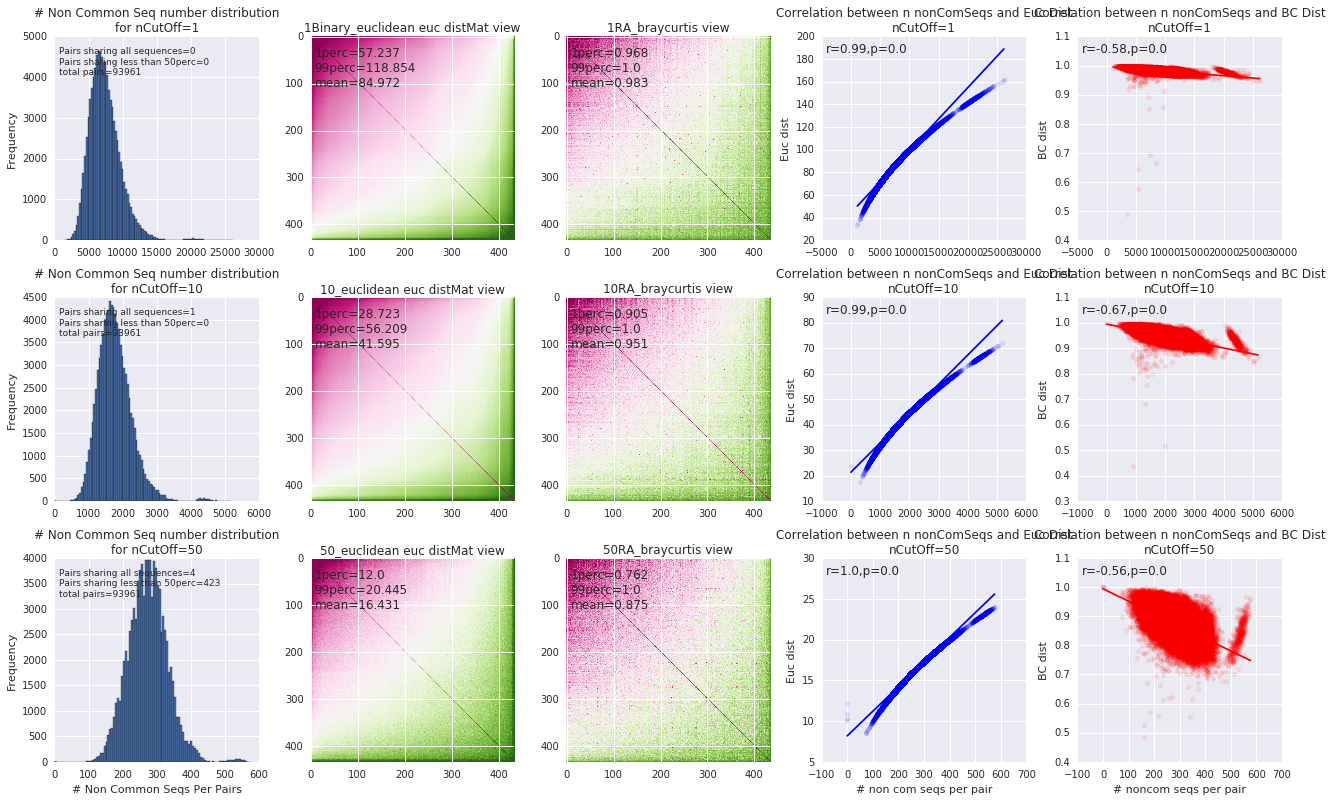

In [26]:
fig, axes = plt.subplots(ncols=5,nrows=3,figsize=(22,13),sharex=False, sharey=False)
nCutOffList=[1,10,50]
totalSeqNumList=[437132,19477,968]

for n,nCutOff in enumerate(nCutOffList):
    
    #(1)plot number of Non-common sequences (appear in one sample only)
    
    file1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Distance Matrices/commonSeqsCountDFs/NonCommonSeqsCount_%s' %nCutOff
    NonCommonSeqsCountDF=pd.read_pickle(file1)
#     print commonSeqsCountDF.tail()

    
    ax=axes[n,0]

    f=ax.hist(NonCommonSeqsCountDF['NonCommonSeqs'],bins=100)
    AllSeqsAreCommon=len(NonCommonSeqsCountDF[NonCommonSeqsCountDF['NonCommonSeqs']==0])
    half=totalSeqNumList[n]*0.5
    print 'half=%s' %half
    moreThan50PercNonCom=len(NonCommonSeqsCountDF[NonCommonSeqsCountDF['NonCommonSeqs']>half])
    total=len(NonCommonSeqsCountDF)
    ax.set_title('# Non Common Seq number distribution\nfor nCutOff=%s' %nCutOff)
    ax.annotate('Pairs sharing all sequences=%s\nPairs sharing less than 50perc=%s\ntotal pairs=%s' %(AllSeqsAreCommon,moreThan50PercNonCom,
                    total), xy=(0.02, 0.95), xycoords='axes fraction', 
                horizontalalignment='left', verticalalignment='top',fontsize=9)
    if n==2:
        ax.set_xlabel('# Non Common Seqs Per Pairs')
    ax.set_ylabel('Frequency')
    
    #(2)plot distMat matrices:
    
    #2.a plot euc distMat matrices:
    print 'plotting euc distMat matrix:...'
    distMatEucList=['1Binary_euclidean','10_euclidean','50_euclidean']
    distMatEucFile='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Distance Matrices/Features/distMat_PNP434_sharingMatrixMoreThan%s' %distMatEucList[n]  
    distMatEuc=pd.read_pickle(distMatEucFile)    
    
    vmin=np.percentile(distMatEuc.values,1)
    vmax=np.percentile(distMatEuc.values,99)
    Mean=np.mean(distMatEuc.values)
    
#     print n, distMatName
    ax=axes[n,1]
    distMatEuc=process_sample_matrix(distMatEuc,removeSameUser=False,orderMethod='sum')
    f=ax.imshow(distMatEuc,cmap='PiYG',vmin=vmin,vmax=vmax)
    ax.set_title('%s euc distMat view' %distMatEucList[n])
    ax.annotate('1perc=%s\n99perc=%s\nmean=%s' %(round(vmin,3),round(vmax,3),round(Mean,3)), xy=(0.02, 0.95), xycoords='axes fraction', 
                horizontalalignment='left', verticalalignment='top')
    
    #2.b plot euc distMat matrices:
    print 'plotting bc distMat matrix:...'
    distMatBCList=['1RA_braycurtis','10RA_braycurtis','50RA_braycurtis']
    distMatBCFile='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Distance Matrices/Features/distMat_PNP434_sharingMatrixMoreThan%s' %distMatBCList[n]  
    distMatBC=pd.read_pickle(distMatBCFile)    
    
    vmin=np.percentile(distMatBC.values,1)
    vmax=1
    print vmin, vmax
    Mean=np.mean(distMatBC.values)
    
#     print n, distMatName
    ax=axes[n,2]
    distMatBC=process_sample_matrix(distMatBC,removeSameUser=False,orderMethod='sum')
    f=ax.imshow(distMatBC,cmap='PiYG',vmin=vmin,vmax=vmax)
    ax.set_title('%s view' %distMatBCList[n])
    ax.annotate('1perc=%s\n99perc=%s\nmean=%s' %(round(vmin,3),round(vmax,3),round(Mean,3)), xy=(0.02, 0.95), xycoords='axes fraction', 
                horizontalalignment='left', verticalalignment='top')
    
    
    #(3) plot correlations between n non common samples with distances:
    nonComSeqsEucDistBCDist=gen_nonComSeqs_withDistances(nCutOff)
    
    ##3.1 plot correlations between nComSeqs and euc distances:
    ax=axes[n,3]
    x=nonComSeqsEucDistBCDist['NonCommonSeqs']
    y1=nonComSeqsEucDistBCDist['distance_x']
        
    r_euc,p_euc=MyPearsonr(x,y1)

    f=ax.scatter(x,y1,color='b',alpha=0.1)
    ax.set_title('Correlation between n nonComSeqs and Euc Dist\nnCutOff=%s' %nCutOff)
    plot_bestFitLine(x,y1,ax,color='b')
    ax.annotate('r=%s,p=%s' %(round(r_euc,2),round(p_euc,3)),xy=(0.02, 0.97), xycoords='axes fraction', 
                horizontalalignment='left', verticalalignment='top')
    if n==2:
        ax.set_xlabel('# non com seqs per pair')
    ax.set_ylabel('Euc dist')
    
    ##3.2 plot correlations between non ComSeqs and euc distances:
    ax=axes[n,4]
    x=nonComSeqsEucDistBCDist['NonCommonSeqs']
    y2=nonComSeqsEucDistBCDist['distance_y']
 
    r_bc,p_bc=MyPearsonr(x,y2)

    f=ax.scatter(x,y2,color='r',alpha=0.1)
    ax.set_title('Correlation between n nonComSeqs and BC Dist\nnCutOff=%s' %nCutOff)
    plot_bestFitLine(x,y2,ax,color='r')
    ax.annotate('r=%s,p=%s' %(round(r_bc,2),round(p_bc,3)), xy=(0.02, 0.97), xycoords='axes fraction', 
                horizontalalignment='left', verticalalignment='top')
    if n==2:
        ax.set_xlabel('# noncom seqs per pair')
    ax.set_ylabel('BC dist')
    
fig.subplots_adjust(wspace=0.25,hspace=0.28) 
file4='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Distance Matrices/Dist mat views and analysis/nonComSeqsEucDistBCDistPlot_%s' %cdate
fig.savefig(file4,dpi=200)
plt.show()

# Toy matrix to understand distance calculations:

In [ ]:
toyDF=pd.DataFrame(index=['s1','s2','s3','s4','s5'],data={'a':[0,1,0,0,1],'b':[0,1,1,1,0],'c':[0,1,0,0,1],'d':[0,1,1,1,0]})
toyDF

In [ ]:
from Feature_phenotype_functions import compute_distance_matrix_general

In [ ]:
matrix_name='toy'
matrix_df=toyDF
distance_measure='euclidean'
do_binary=False


temp_res=compute_distance_matrix_general(matrix_name,matrix_df, distance_measure, do_binary)

temp_res

In [ ]:
matrix_name='toy'
matrix_df=toyDF
distance_measure='braycurtis'
do_binary=False


temp_res=compute_distance_matrix_general(matrix_name,matrix_df, distance_measure, do_binary)

temp_res

In [ ]:
matrix_name='toy'
matrix_df=toyDF
distance_measure='jaccard'
do_binary=False


temp_res=compute_distance_matrix_general(matrix_name,matrix_df, distance_measure, do_binary)

temp_res

In [ ]:
toyEverything=pd.DataFrame(index=['s1-s1','s1-s3','s1-s4','s1-s5','s2-s3','s2-s4','s2-s5','s3-s4',
                                  's3-s5','s4-s5'],data={'com':[0,0,0,0,2,2,2,2,0,0],
                                    'in1':[4,2,2,2,2,2,2,0,4,4],'euc':[2,1.41,1.41,1.41,1.41,1.41,
                                    1.41,0,2,2]})
toyEverything

In [ ]:
x=toyEverything['com']
y=toyEverything['euc']
z=toyEverything['in1']

r,p=MyPearsonr(x,y)
print r,p

r,p=MyPearsonr(y,z)
print r,p

In [ ]:
math.factorial(3)

In [ ]:
sum(range(434))

# plotting hierarchial clustering dendigrams with different distance metrix to see which captures the relationships between samples:

1. 50RA - braycurtis
2. 50binary euclidean
3. 50binary jaccard
4. repeat all for 1. 

50 _RA euclidean


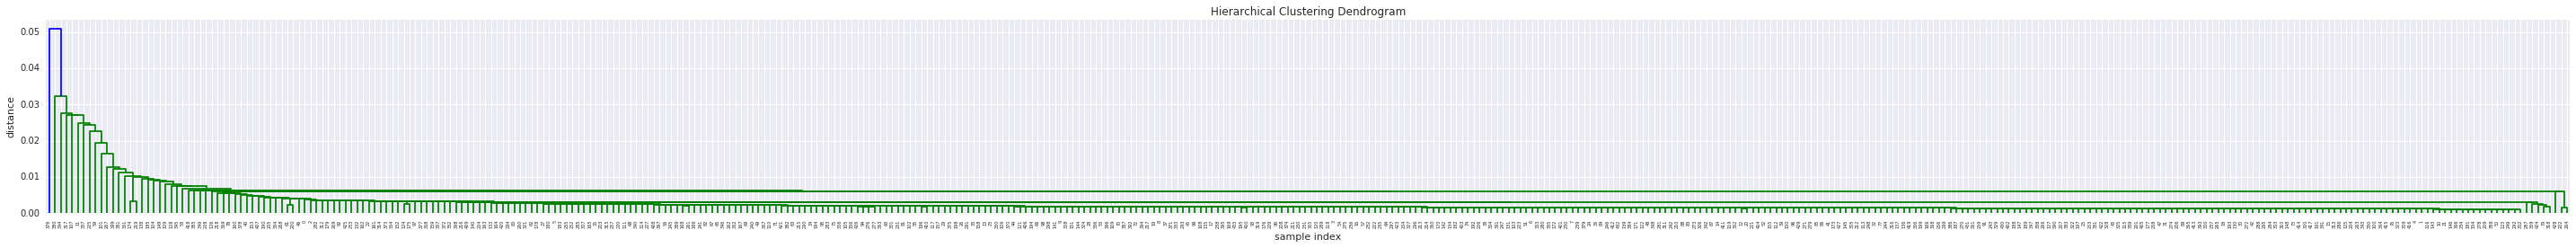

        0      1         2 sample1 sample2  \
0   292.0  302.0  0.000996    BD79   BD134   
1   249.0  434.0  0.001036   BD160       0   
2   123.0  435.0  0.001065   BD679       0   
3    50.0  436.0  0.001086   BD700       0   
4   388.0  437.0  0.001086   BD140       0   
5   209.0  438.0  0.001099   BD728       0   
6   278.0  439.0  0.001117   BD148       0   
7   154.0  440.0  0.001123    BD29       0   
8   181.0  441.0  0.001126   BD159       0   
9   234.0  442.0  0.001136   BD798       0   
10  366.0  443.0  0.001139   BD856       0   
11  146.0  444.0  0.001146   BD123       0   
12   21.0  445.0  0.001146   BD391       0   
13   10.0  446.0  0.001153   BD153       0   
14  143.0  447.0  0.001156   BD333       0   
15  116.0  448.0  0.001163   BD870       0   
16    1.0  449.0  0.001163   BD690       0   
17    4.0  450.0  0.001168   BD443       0   
18  416.0  451.0  0.001171     BD2       0   
19  309.0  452.0  0.001178     BD4       0   

                                 

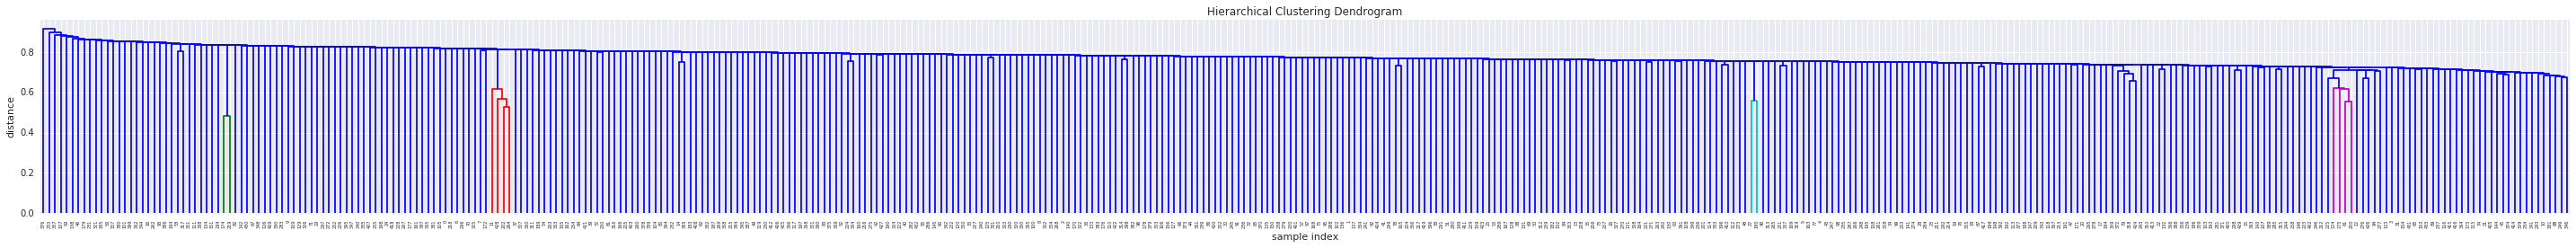

        0      1         2 sample1 sample2  \
0   174.0  219.0  0.485412   BD714   BD705   
1   202.0  264.0  0.527501   BD481   BD314   
2    61.0  200.0  0.553364   BD113   BD317   
3    27.0  180.0  0.557162   BD838   BD617   
4   428.0  435.0  0.569411   BD800       0   
5   175.0  436.0  0.616530   BD413       0   
6    11.0  438.0  0.617497   BD349       0   
7   124.0  439.0  0.622462   BD894       0   
8   318.0  424.0  0.656136   BD441   BD558   
9   276.0  426.0  0.669327   BD408   BD670   
10  225.0  441.0  0.670600   BD694       0   
11  249.0  346.0  0.676823   BD160   BD146   
12   68.0  445.0  0.677727    BD13       0   
13  181.0  446.0  0.683495   BD159       0   
14   10.0  447.0  0.686085   BD153       0   
15   45.0  374.0  0.690961   BD151   BD145   
16   79.0  442.0  0.693942   BD883       0   
17  293.0  448.0  0.694134   BD136       0   
18  144.0  449.0  0.695486   BD902       0   
19  341.0  451.0  0.697172   BD367       0   

                                 

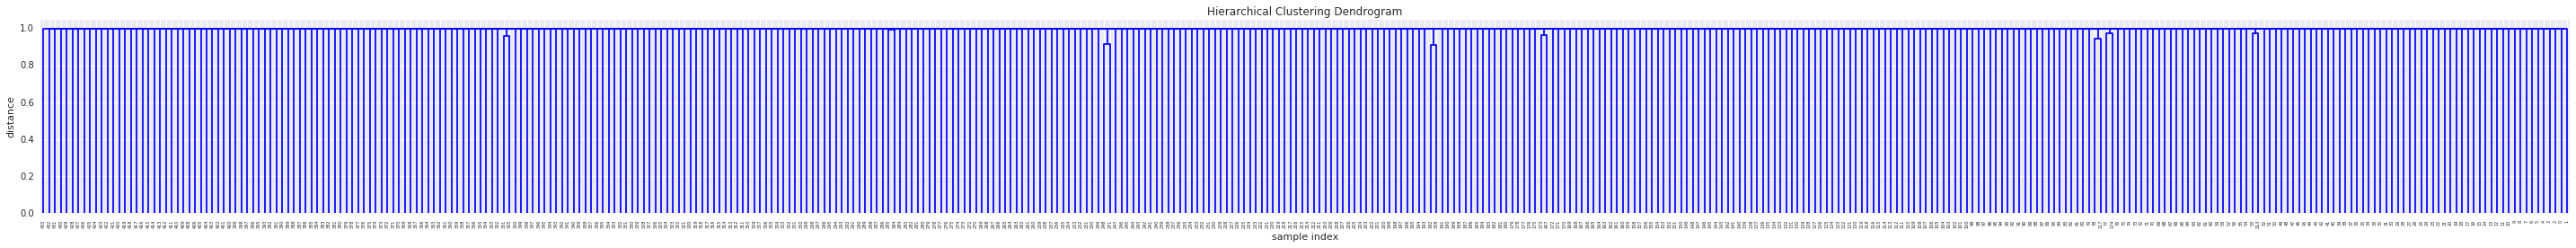

        0      1         2 sample1 sample2  \
0   192.0  308.0  0.913242   BD739   BD897   
1   248.0  271.0  0.917143   BD239   BD419   
2    78.0  117.0  0.948498   BD272   BD402   
3   351.0  365.0  0.960000   BD696   BD383   
4   173.0  407.0  0.966581    BD27   BD697   
5    77.0  174.0  0.973451    BD26   BD714   
6    53.0  213.0  0.976401   BD538   BD859   
7   285.0  394.0  0.994334   BD699   BD496   
8   441.0  721.0  1.000000       0       0   
9   286.0  722.0  1.000000   BD664       0   
10  287.0  723.0  1.000000   BD137       0   
11  288.0  724.0  1.000000   BD377       0   
12  292.0  728.0  1.000000    BD79       0   
13  290.0  726.0  1.000000   BD695       0   
14  291.0  727.0  1.000000   BD668       0   
15  284.0  720.0  1.000000   BD801       0   
16  293.0  729.0  1.000000   BD136       0   
17  289.0  725.0  1.000000   BD401       0   
18  283.0  719.0  1.000000   BD473       0   
19  279.0  715.0  1.000000   BD645       0   

                                 

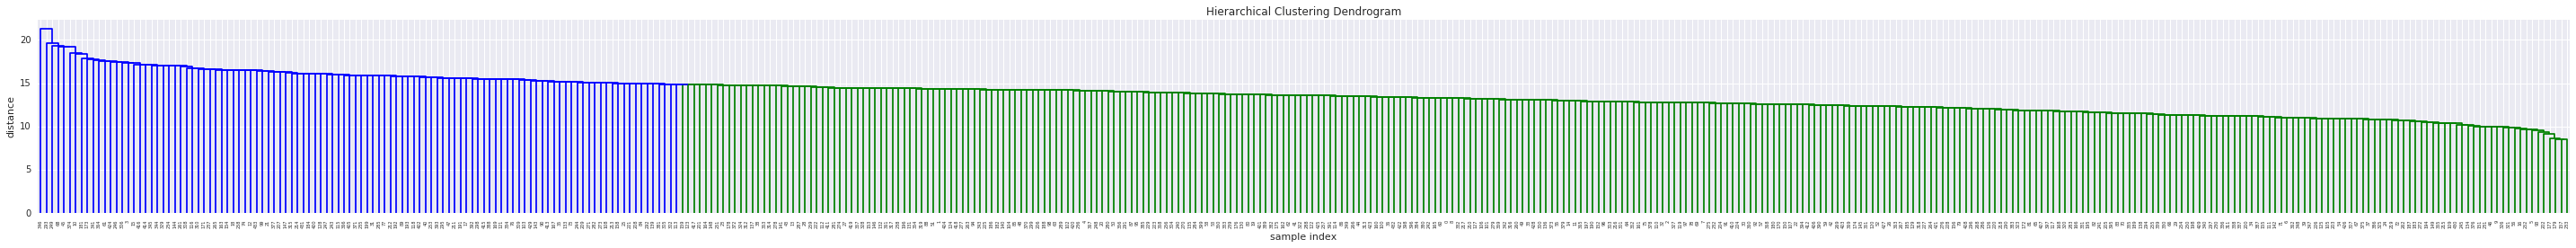

        0      1          2 sample1 sample2  \
0   157.0  233.0   8.485281   BD453   BD328   
1   179.0  434.0   8.544004   BD319       0   
2   177.0  435.0   8.660254   BD537       0   
3   202.0  436.0   9.165151   BD481       0   
4    93.0  437.0   9.380832   BD484       0   
5     5.0  438.0   9.591663   BD831       0   
6   252.0  439.0   9.643651   BD548       0   
7    16.0  440.0   9.695360   BD640       0   
8    56.0  441.0   9.746794   BD467       0   
9   321.0  442.0   9.848858   BD611       0   
10  326.0  443.0   9.848858   BD667       0   
11  231.0  446.0   9.949874   BD606       0   
12   46.0  445.0   9.949874   BD656       0   
13    9.0  444.0   9.949874   BD398       0   
14  151.0  447.0  10.000000   BD322       0   
15  376.0  448.0  10.000000   BD487       0   
16  134.0  449.0  10.099505   BD830       0   
17  245.0  450.0  10.148892   BD673       0   
18  430.0  451.0  10.198039   BD579       0   
19  109.0  452.0  10.344080   BD521       0   

            

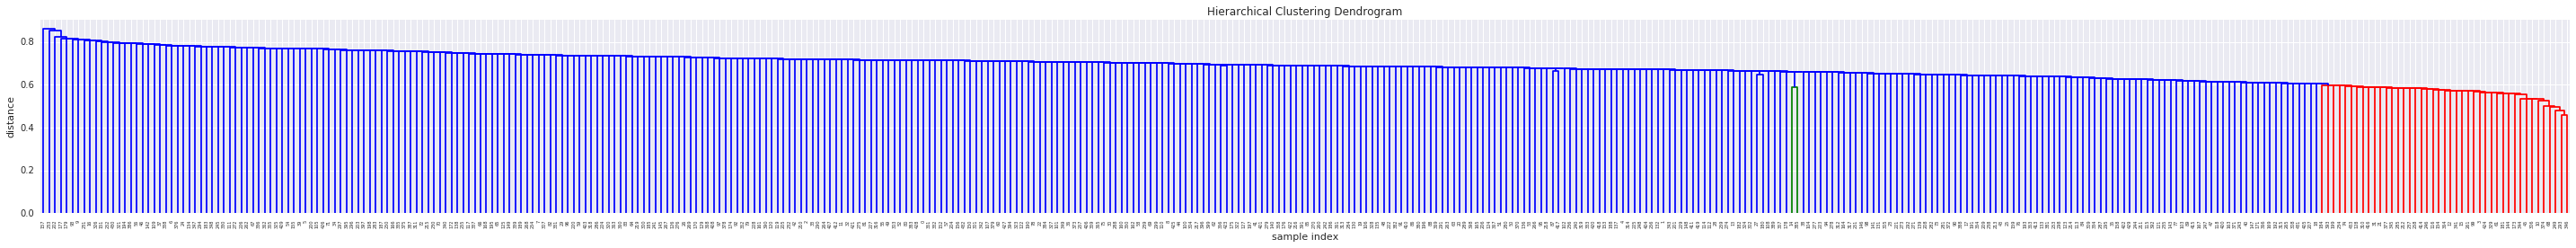

        0      1         2 sample1 sample2  \
0   293.0  346.0  0.459898   BD136   BD146   
1   249.0  434.0  0.481405   BD160       0   
2    68.0  435.0  0.498446    BD13       0   
3   374.0  436.0  0.501066   BD145       0   
4    10.0  437.0  0.526602   BD153       0   
5   306.0  438.0  0.534091     BD3       0   
6    45.0  439.0  0.535565   BD151       0   
7   344.0  440.0  0.536671   BD535       0   
8   173.0  441.0  0.554810    BD27       0   
9   144.0  442.0  0.558559   BD902       0   
10  181.0  443.0  0.560538   BD159       0   
11   61.0  444.0  0.561582   BD113       0   
12  329.0  445.0  0.564014   BD231       0   
13  424.0  446.0  0.565119   BD558       0   
14    3.0  447.0  0.566210   BD701       0   
15   99.0  448.0  0.570248   BD124       0   
16  261.0  449.0  0.570766   BD118       0   
17   15.0  450.0  0.570934   BD843       0   
18  341.0  451.0  0.571590   BD367       0   
19   12.0  452.0  0.573113    BD30       0   

                         Relation

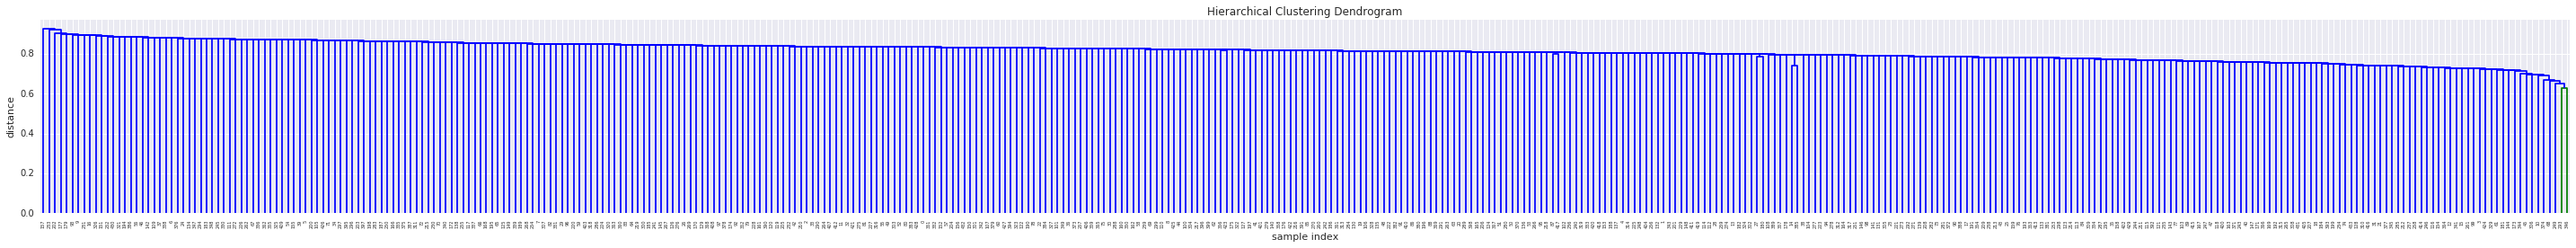

        0      1         2 sample1 sample2  \
0   293.0  346.0  0.630042   BD136   BD146   
1   249.0  434.0  0.649930   BD160       0   
2    68.0  435.0  0.665284    BD13       0   
3   374.0  436.0  0.667614   BD145       0   
4    10.0  437.0  0.689900   BD153       0   
5   306.0  438.0  0.696296     BD3       0   
6    45.0  439.0  0.697548   BD151       0   
7   344.0  440.0  0.698485   BD535       0   
8   173.0  441.0  0.713669    BD27       0   
9   144.0  442.0  0.716763   BD902       0   
10  181.0  443.0  0.718391   BD159       0   
11   61.0  444.0  0.719247   BD113       0   
12  329.0  445.0  0.721239   BD231       0   
13  424.0  446.0  0.722142   BD558       0   
14    3.0  447.0  0.723032   BD701       0   
15   99.0  448.0  0.726316   BD124       0   
16  261.0  449.0  0.726736   BD118       0   
17   15.0  450.0  0.726872   BD843       0   
18  341.0  451.0  0.727403   BD367       0   
19   12.0  452.0  0.728636    BD30       0   

                         Relation

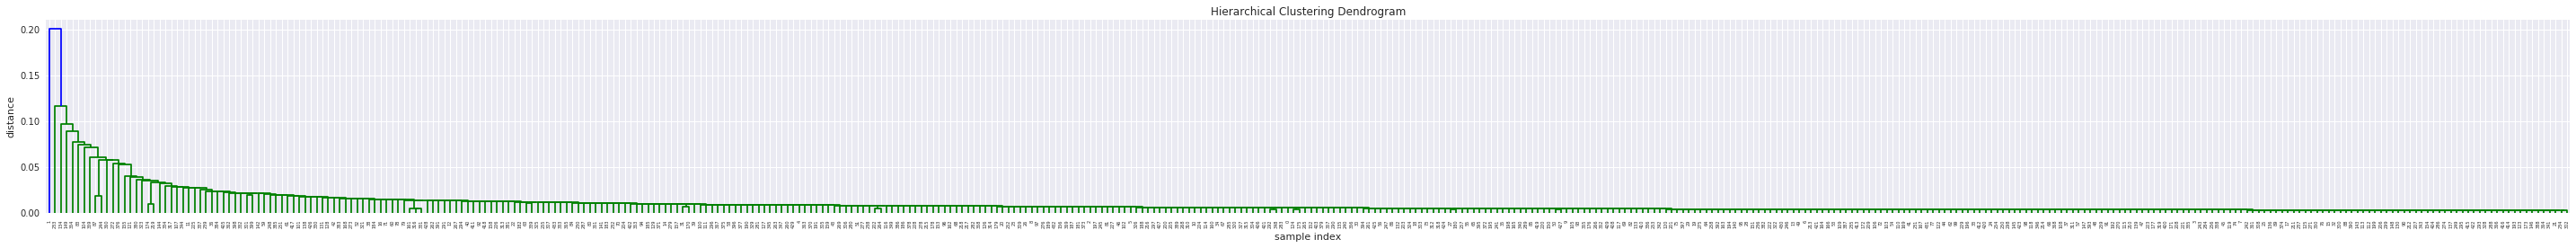

        0      1         2 sample1 sample2  \
0   234.0  302.0  0.002807   BD798   BD134   
1    21.0  434.0  0.002894   BD391       0   
2   341.0  435.0  0.002939   BD367       0   
3   364.0  436.0  0.002941   BD887       0   
4   388.0  437.0  0.002944   BD140       0   
5   146.0  438.0  0.002950   BD123       0   
6   173.0  439.0  0.002963    BD27       0   
7   123.0  440.0  0.002964   BD679       0   
8   193.0  441.0  0.002974   BD233       0   
9   414.0  442.0  0.002977   BD112       0   
10  416.0  443.0  0.002997     BD2       0   
11  366.0  444.0  0.003034   BD856       0   
12  288.0  445.0  0.003050   BD377       0   
13  328.0  446.0  0.003066   BD764       0   
14  293.0  447.0  0.003093   BD136       0   
15  422.0  448.0  0.003095   BD376       0   
16  415.0  449.0  0.003106   BD706       0   
17  295.0  450.0  0.003113   BD808       0   
18  249.0  451.0  0.003163   BD160       0   
19  137.0  452.0  0.003164   BD126       0   

                                R

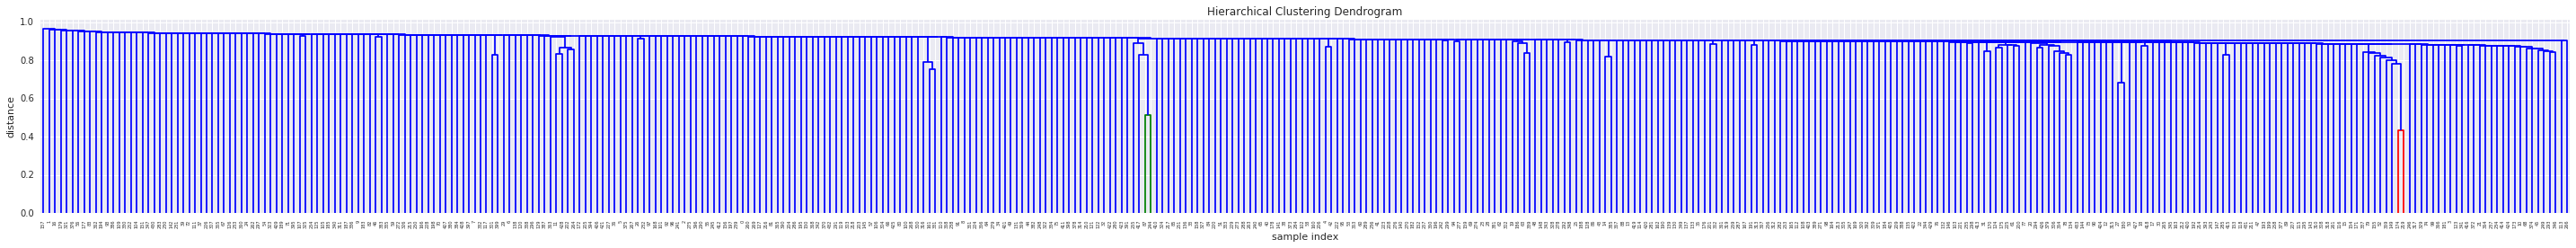

        0      1         2 sample1 sample2  \
0   174.0  219.0  0.435721   BD714   BD705   
1    87.0  244.0  0.514259   BD788   BD245   
2    27.0  180.0  0.682381   BD838   BD617   
3   161.0  331.0  0.755588   BD505   BD547   
4   149.0  434.0  0.782145   BD620       0   
5   316.0  437.0  0.792575   BD834       0   
6   359.0  438.0  0.800538   BD355       0   
7    52.0  440.0  0.815575   BD603       0   
8    14.0  385.0  0.820376   BD431   BD440   
9   155.0  441.0  0.826721   BD702       0   
10  301.0  399.0  0.827809   BD517   BD896   
11   78.0  134.0  0.828318   BD272   BD830   
12  285.0  415.0  0.829111   BD699   BD706   
13  417.0  435.0  0.829697   BD809       0   
14   11.0  428.0  0.834700   BD349   BD800   
15  354.0  445.0  0.840066   BD574       0   
16   63.0  339.0  0.840296   BD363   BD863   
17   79.0  443.0  0.840971   BD883       0   
18  293.0  346.0  0.842008   BD136   BD146   
19  337.0  451.0  0.845843   BD726       0   

                                 

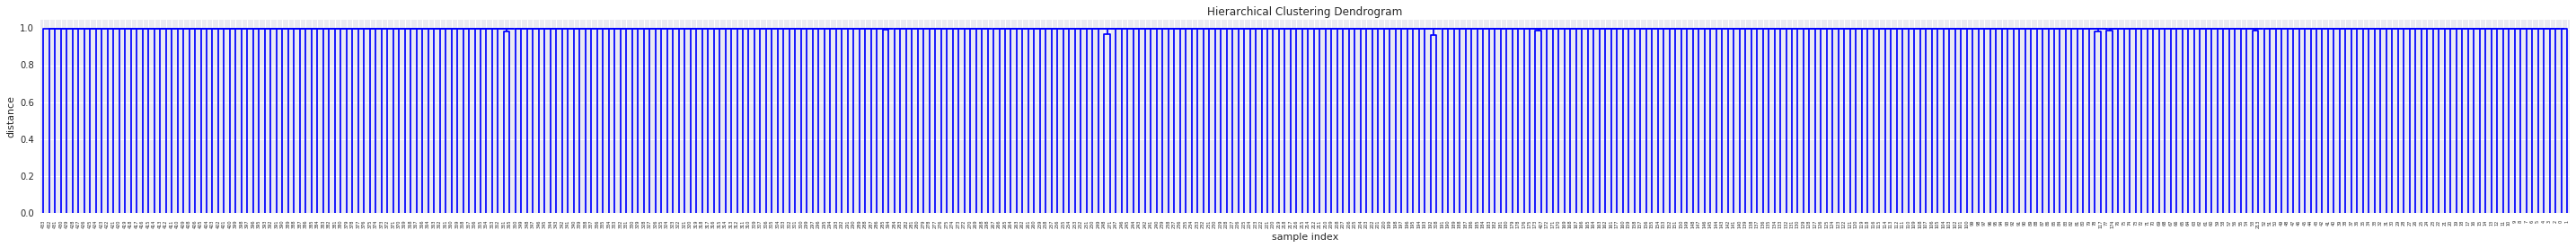

        0      1         2 sample1 sample2  \
0   192.0  308.0  0.966702   BD739   BD897   
1   248.0  271.0  0.973057   BD239   BD419   
2    78.0  117.0  0.983957   BD272   BD402   
3   351.0  365.0  0.985537   BD696   BD383   
4   173.0  407.0  0.989157    BD27   BD697   
5    53.0  213.0  0.991645   BD538   BD859   
6    77.0  174.0  0.991988    BD26   BD714   
7   285.0  394.0  0.996918   BD699   BD496   
8   161.0  177.0  0.999051   BD505   BD537   
9   268.0  298.0  0.999474    BD18   BD725   
10  441.0  722.0  1.000000       0       0   
11  286.0  723.0  1.000000   BD664       0   
12  287.0  724.0  1.000000   BD137       0   
13  288.0  725.0  1.000000   BD377       0   
14  293.0  730.0  1.000000   BD136       0   
15  290.0  727.0  1.000000   BD695       0   
16  291.0  728.0  1.000000   BD668       0   
17  292.0  729.0  1.000000    BD79       0   
18  284.0  721.0  1.000000   BD801       0   
19  289.0  726.0  1.000000   BD401       0   

                                 

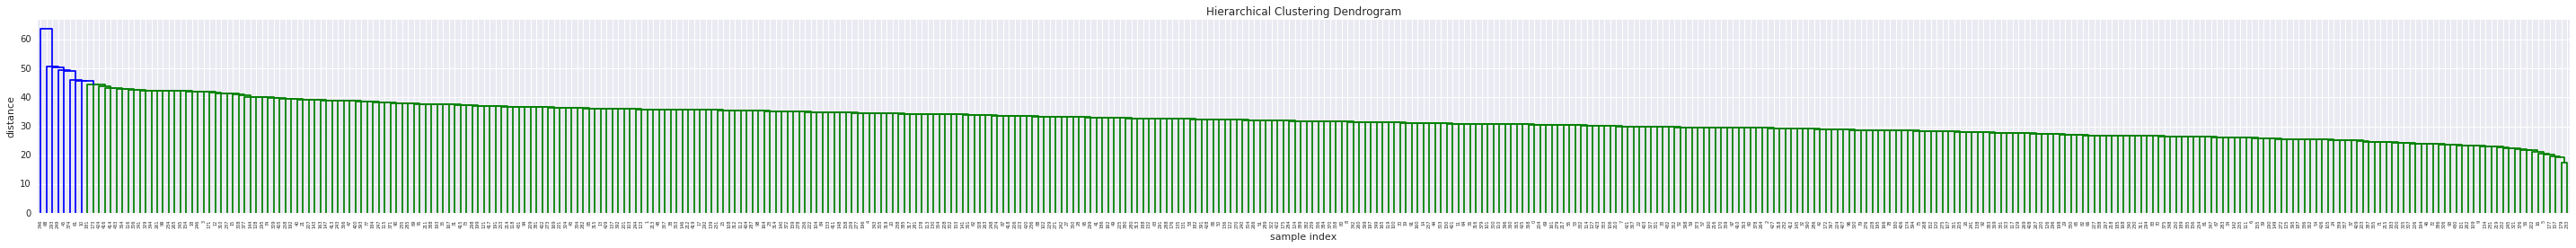

        0      1          2 sample1 sample2  \
0   179.0  233.0  17.464249   BD319   BD328   
1   157.0  434.0  19.390719   BD453       0   
2   177.0  435.0  19.748418   BD537       0   
3     5.0  436.0  20.396078   BD831       0   
4    16.0  437.0  20.420578   BD640       0   
5   202.0  438.0  21.118712   BD481       0   
6    56.0  439.0  21.725561   BD467       0   
7   376.0  440.0  21.794495   BD487       0   
8   321.0  441.0  22.045408   BD611       0   
9   245.0  442.0  22.472205   BD673       0   
10  252.0  443.0  22.494444   BD548       0   
11  219.0  444.0  22.869193   BD705       0   
12  231.0  445.0  22.978251   BD606       0   
13  134.0  446.0  23.000000   BD830       0   
14    9.0  447.0  23.108440   BD398       0   
15  109.0  448.0  23.366643   BD521       0   
16  262.0  449.0  23.366643   BD631       0   
17  151.0  450.0  23.430749   BD322       0   
18  430.0  451.0  23.452079   BD579       0   
19   93.0  452.0  23.643181   BD484       0   

            

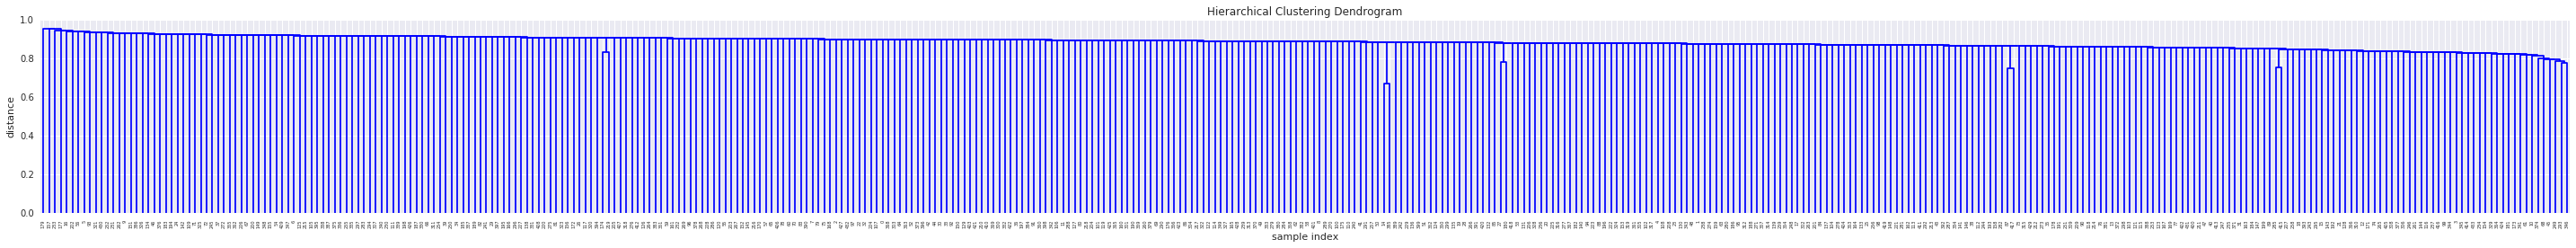

        0      1         2 sample1 sample2  \
0    14.0  385.0  0.669638   BD431   BD440   
1    87.0  417.0  0.749561   BD788   BD809   
2   285.0  415.0  0.755025   BD699   BD706   
3   293.0  346.0  0.778843   BD136   BD146   
4    27.0  180.0  0.780531   BD838   BD617   
5   249.0  437.0  0.785479   BD160       0   
6    45.0  439.0  0.794864   BD151       0   
7    68.0  440.0  0.794872    BD13       0   
8   374.0  441.0  0.798875   BD145       0   
9    10.0  442.0  0.813698   BD153       0   
10   61.0  443.0  0.817364   BD113       0   
11  341.0  444.0  0.820535   BD367       0   
12  173.0  445.0  0.823021    BD27       0   
13  181.0  446.0  0.823159   BD159       0   
14  424.0  447.0  0.823469   BD558       0   
15  364.0  448.0  0.824072   BD887       0   
16  329.0  449.0  0.825569   BD231       0   
17  154.0  450.0  0.826531    BD29       0   
18  234.0  451.0  0.826561   BD798       0   
19  433.0  452.0  0.826630   BD107       0   

                                 

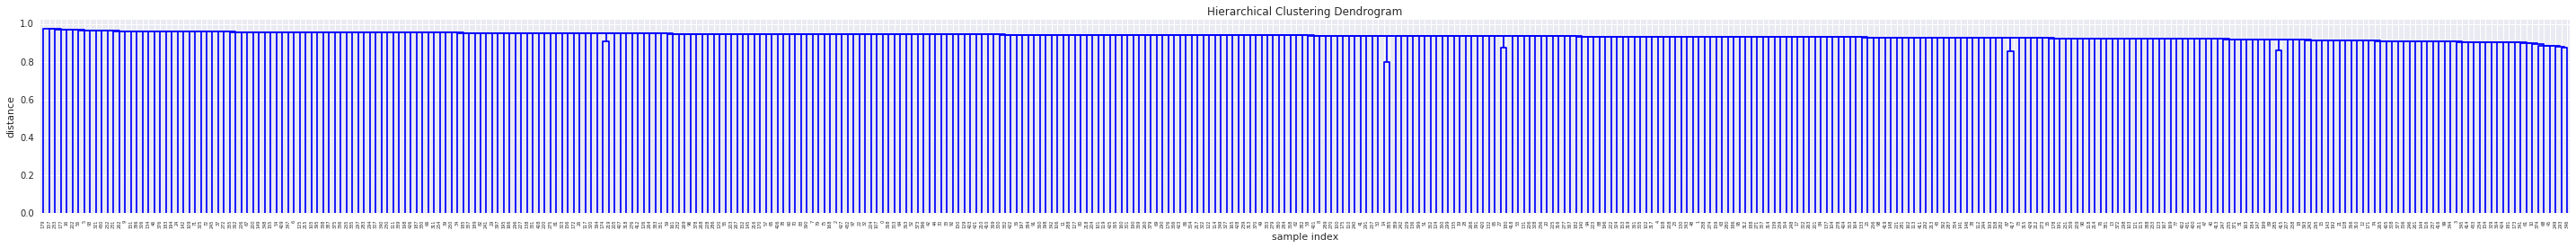

        0      1         2 sample1 sample2  \
0    14.0  385.0  0.802136   BD431   BD440   
1    87.0  417.0  0.856856   BD788   BD809   
2   285.0  415.0  0.860415   BD699   BD706   
3   293.0  346.0  0.875674   BD136   BD146   
4    27.0  180.0  0.876740   BD838   BD617   
5   249.0  437.0  0.879852   BD160       0   
6    45.0  439.0  0.885709   BD151       0   
7    68.0  440.0  0.885714    BD13       0   
8   374.0  441.0  0.888194   BD145       0   
9    10.0  442.0  0.897280   BD153       0   
10   61.0  443.0  0.899505   BD113       0   
11  341.0  444.0  0.901422   BD367       0   
12  173.0  445.0  0.902920    BD27       0   
13  181.0  446.0  0.903003   BD159       0   
14  424.0  447.0  0.903189   BD558       0   
15  364.0  448.0  0.903552   BD887       0   
16  329.0  449.0  0.904451   BD231       0   
17  154.0  450.0  0.905028    BD29       0   
18  234.0  451.0  0.905046   BD798       0   
19  433.0  452.0  0.905087   BD107       0   

                                 

KeyboardInterrupt: 

In [28]:
file6='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/GenRelationsWithBDs_final.xlsx'
GenRelationsWithBDs_final=pd.read_excel(file6)

relationsSmall=GenRelationsWithBDs_final[['DnaID','Relations']]
relationsSmall.head()


from scipy.cluster.hierarchy import dendrogram, linkage
nShared_cutoff_List=[50,10,1]
RAlist=['_RA','']
metricList=['euclidean','braycurtis', 'jaccard']

for nShared_cutoff in nShared_cutoff_List:
    for RA in RAlist:

        
        #load file:
        matrix_file='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/PublicSeqAnalysis/sharingMatrix_moreThan%s_434Samples%s' %(nShared_cutoff, RA)
        matrix_df=pd.read_pickle(matrix_file)
        
        matrix_df=editSampleNames(matrix_df)
        for metric in metricList:
            print nShared_cutoff,RA,metric
            
            Z=linkage(matrix_df, metric=metric)
            
            fig, ax = plt.subplots(figsize=(40, 4))
            # calculate full dendrogram

            ax.set_title('Hierarchical Clustering Dendrogram')
            ax.set_xlabel('sample index')
            ax.set_ylabel('distance')
            dendrogram(
                Z,
                leaf_rotation=90.,  # rotates the x axis labels
                leaf_font_size=5.,  # font size for the x axis labels
            )
            fig.tight_layout()
            plt.show()

            file4='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Distance Matrices/Dist mat views and analysis/dendogram_%s%s_%s'\
            %(nShared_cutoff,RA,metric)
            fig.savefig(file4,dpi=200)
            
            dfZ=pd.DataFrame(Z)
            dfZ_top=dfZ.sort_values(by=2).head(20)
            for n in dfZ_top.index:
                id1=int(dfZ_top.loc[n,0])
                id2=int(dfZ_top.loc[n,1])
            #     print id1,id2
                if id1 < len(matrix_df):
                    dfZ_top.loc[n,'sample1']=matrix_df.index[id1]
                if id2 < len(matrix_df):
                    dfZ_top.loc[n,'sample2']=matrix_df.index[id2]
            dfZ_top=dfZ_top.fillna(0)       
            dfZ_top_withComments=pd.merge(dfZ_top,relationsSmall,how='left',left_on='sample1',right_on='DnaID')
            dfZ_top_withComments=dfZ_top_withComments.rename(columns={'Relations':'Relations-sample1'})
            dfZ_top_withComments=pd.merge(dfZ_top_withComments,relationsSmall,how='left',left_on='sample2',right_on='DnaID')
            dfZ_top_withComments=dfZ_top_withComments.rename(columns={'Relations':'Relations-sample2'})
            dfZ_top_withComments=dfZ_top_withComments.drop('DnaID_x',axis=1)
            dfZ_top_withComments=dfZ_top_withComments.drop('DnaID_y',axis=1)
            dfZ_top_withComments=dfZ_top_withComments.drop(3,axis=1)
            print dfZ_top_withComments
            file5='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Distance Matrices/Dist mat views and analysis/closestSamplesIdentified_%s%s_%s'\
            %(nShared_cutoff,RA,metric)
            dfZ_top.to_pickle(file5)
        
        
        

# compare linkage calculations to distance matrices

In [30]:
nCutOffList=[1,10,50]
RA='_RA'
metric='braycurtis'

for n,nCutOff in enumerate(nCutOffList):
    
    ComSeqsEucDistBCDist=gen_comSeqs_withDistances(nCutOff)
    print nCutOff
    print 'top20 by existing bc distance matrix:'
    print ComSeqsEucDistBCDist.sort_values(by='distance_y').head(20)
    
    file5='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Distance Matrices/Dist mat views and analysis/closestSamplesIdentified_%s%s_%s'\
            %(nCutOff,RA,metric)
    dfZ_top=pd.read_pickle(file5)
    print 'top20 by linkage:'
    print dfZ_top

generating comSeqs_withDistances DF...
1
top20 by existing bc distance matrix:
      sample1 sample2  nCommonSeqs  distance_x  distance_y
93866   BD714   BD705        489.0   59.632206    0.488406
93957   BD838   BD617       1191.0   73.539105    0.574687
93960   BD431   BD440       3545.0   73.239334    0.645468
93959   BD699   BD706       3391.0   91.880357    0.665130
93958   BD788   BD809       2398.0   85.638776    0.691209
93919   BD508   BD507        597.0   84.852814    0.851137
74289   BD788   BD245        126.0   97.749680    0.857599
93945   BD339   BD337        701.0   84.409715    0.891554
93951   BD273   BD231        758.0   99.176610    0.912126
4231    BD620   BD705         27.0   60.770058    0.919866
24320   BD505   BD547         54.0   75.855125    0.924830
7283    BD705   BD355         33.0   66.873014    0.927567
13284   BD620   BD714         42.0   68.927498    0.930401
3909    BD272   BD830         26.0   63.419240    0.930742
34787   BD714   BD355         66.0  

# load all linkage results:

In [36]:
nShared_cutoff_List=[50,10,1]
RAlist=['_RA','']
metricList=['euclidean','braycurtis']

for nShared_cutoff in nShared_cutoff_List:
    ComSeqsEucDistBCDist=gen_comSeqs_withDistances(nShared_cutoff)
    for RA in RAlist:
        for metric in metricList:
            if (RA=='_RA') and (metric=='braycurtis'):
                print nShared_cutoff,RA,metric
                print ComSeqsEucDistBCDist.sort_values(by='distance_y')[:20]
            elif (RA=='') and (metric=='euclidean'):
                print nShared_cutoff,RA,metric
                print ComSeqsEucDistBCDist.sort_values(by='distance_x')[:20]
                
            
            
            

generating comSeqs_withDistances DF...
50 _RA braycurtis
      sample1 sample2  nCommonSeqs  distance_x  distance_y
41289   BD714   BD705         29.0   12.649111    0.485412
9989    BD481   BD314         15.0   12.609520    0.527501
48153   BD113   BD317         32.0   18.493242    0.553364
82969   BD838   BD617         58.0   14.628739    0.557162
5050    BD481   BD800         11.0   13.601471    0.569411
34308   BD314   BD800         26.0   15.297059    0.611940
85560   BD113   BD413         62.0   18.681542    0.616530
22854   BD349   BD800         21.0   16.031220    0.617497
67456   BD894   BD413         43.0   16.370706    0.622462
85565   BD113   BD894         62.0   19.261360    0.649546
74580   BD441   BD558         48.0   18.220867    0.656136
25639   BD413   BD317         22.0   14.866069    0.663251
33988   BD408   BD670         26.0   13.114877    0.669327
84278   BD113   BD694         60.0   19.235384    0.670600
93959   BD160   BD146        251.0   21.587033    0.676823

# add relationship comments to comSeq-distance files

In [78]:
file6='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/GenRelationsWithBDs_final.xlsx'
GenRelationsWithBDs_final=pd.read_excel(file6)

relationsSmall=GenRelationsWithBDs_final[['DnaID','Relations']]
relationsSmall.head()


nShared_cutoff_List=[50,10,1]

for nShared_cutoff in nShared_cutoff_List:
    print nShared_cutoff
    ComSeqsEucDistBCDist=gen_comSeqs_withDistances(nShared_cutoff)
    ComSeqsEucDistBCDist=ComSeqsEucDistBCDist.rename(columns={'distance_x':'Euclidean','distance_y':'braycurtis'})
    
    ComSeqsEucDistBCDist_withComments=pd.merge(ComSeqsEucDistBCDist,relationsSmall,how='left',left_on='sample1',right_on='DnaID')
    ComSeqsEucDistBCDist_withComments=ComSeqsEucDistBCDist_withComments.rename(columns={'Relations':'Relations-sample1'})
    ComSeqsEucDistBCDist_withComments=pd.merge(ComSeqsEucDistBCDist_withComments,relationsSmall,how='left',left_on='sample2',right_on='DnaID')
    ComSeqsEucDistBCDist_withComments=ComSeqsEucDistBCDist_withComments.rename(columns={'Relations':'Relations-sample2'})
    ComSeqsEucDistBCDist_withComments=ComSeqsEucDistBCDist_withComments.drop('DnaID_x',axis=1)
    ComSeqsEucDistBCDist_withComments=ComSeqsEucDistBCDist_withComments.drop('DnaID_y',axis=1)
#     dfZ_top_withComments=dfZ_top_withComments.drop(3,axis=1)
    print ComSeqsEucDistBCDist_withComments[:10]
    file5='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Distance Matrices/commonSeqsCountDFs/commonSeqsCount_%s_withComments' %nShared_cutoff
    ComSeqsEucDistBCDist_withComments.to_pickle(file5)
    file6='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Distance Matrices/commonSeqsCountDFs/commonSeqsCount_%s_withComments.xlsx' %nShared_cutoff
    ComSeqsEucDistBCDist_withComments.to_excel(file6)
    

50
generating comSeqs_withDistances DF...
  sample1 sample2  nCommonSeqs  _euclidean  RA_braycurtis  _jaccard  1PCsUsed_euclidean                            Relations-sample1         Relations-sample2
0   BD640   BD328          0.0   10.099505       1.000000  1.000000            0.001391                     husband of BD636(116140)                       NaN
1   BD640   BD631          0.0   12.165525       1.000000  1.000000            0.007019                     husband of BD636(116140)                       NaN
2   BD322   BD319          0.0   10.908712       1.000000  1.000000            0.007000  mother of BD856(598262),don't live together                       NaN
3   BD484   BD328          0.0   10.198039       1.000000  1.000000            0.008610                                          NaN                       NaN
4   BD494   BD453          1.0   11.180340       0.983686  0.992063            0.005745                                          NaN  husband of BD949(787355)
5   

# watch again distance dfs, now with comments:

In [87]:
# pd.set_option('display.height', 1000)
# pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1200)

In [88]:
for nShared_cutoff in nShared_cutoff_List:
    
    file5='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Distance Matrices/commonSeqsCountDFs/commonSeqsCount_%s_withComments' %nShared_cutoff
    ComSeqsEucDistBCDist_withComments=pd.read_pickle(file5)
    print nShared_cutoff,'euclidean'
    print ComSeqsEucDistBCDist_withComments.sort_values(by='_euclidean')[:10]
    print nShared_cutoff,'RA-braycurtis'
    print ComSeqsEucDistBCDist_withComments.sort_values(by='RA_braycurtis')[:10]
    print nShared_cutoff,'jaccard'
    print ComSeqsEucDistBCDist_withComments.sort_values(by='_jaccard')[:10]
    print nShared_cutoff,'1PCsUsed_euclidean'
    print ComSeqsEucDistBCDist_withComments.sort_values(by='1PCsUsed_euclidean')[:10]
    

50 euclidean
     sample1 sample2  nCommonSeqs  _euclidean  RA_braycurtis  _jaccard  1PCsUsed_euclidean         Relations-sample1         Relations-sample2
7      BD453   BD328          1.0    8.485281       0.984286  0.986301            0.005451  husband of BD949(787355)                       NaN
611    BD319   BD328          5.0    8.544004       0.898929  0.935897            0.004292                       NaN                       NaN
57     BD453   BD537          2.0    8.660254       0.972364  0.974026            0.026432  husband of BD949(787355)                       NaN
63     BD537   BD328          2.0    8.774964       0.974484  0.974684            0.020981                       NaN                       NaN
12     BD453   BD319          1.0    8.888194       0.984535  0.987500            0.009743  husband of BD949(787355)                       NaN
144    BD537   BD319          3.0    9.055385       0.966587  0.964706            0.016689                       NaN             

1 euclidean
   sample1 sample2  nCommonSeqs  _euclidean  RA_braycurtis  _jaccard  1PCsUsed_euclidean         Relations-sample1 Relations-sample2
28   BD319   BD328          6.0   33.226495       0.992333  0.994595            0.001981                       NaN               NaN
2    BD453   BD328          3.0   35.580894       0.998092  0.997636            0.002045  husband of BD949(787355)               NaN
9    BD640   BD328          4.0   38.535698       0.998114  0.997314            0.005703  husband of BD636(116140)               NaN
62   BD537   BD328          7.0   38.704005       0.996600  0.995349            0.004290                       NaN               NaN
19   BD453   BD319          5.0   38.884444       0.996560  0.996704            0.000064  husband of BD949(787355)               NaN
1    BD831   BD328          2.0   39.534795       0.999184  0.998722            0.005405                       NaN               NaN
23   BD640   BD319          5.0   41.629317       0.99742

## load shared sequences matrix and edit names:

In [ ]:
nShared_cutoff=50
RA='_RA'

matrix_file='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/PublicSeqAnalysis/sharingMatrix_moreThan%s_434Samples%s' %(nShared_cutoff, RA)
matrix_df=pd.read_pickle(matrix_file)
matrix_df.head()

In [ ]:
matrix_df=editSampleNames(matrix_df)
matrix_df.head()

## calculate clustering linkage:

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [ ]:
Z=linkage(matrix_df, metric='braycurtis')
#, optimal_ordering=False)

## plot dendogram

In [ ]:
metric='braycurtis'
Z=linkage(matrix_df, metric=metric)
fig, ax = plt.subplots(figsize=(40, 4))
# calculate full dendrogram

ax.set_title('Hierarchical Clustering Dendrogram')
ax.set_xlabel('sample index')
ax.set_ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=5.,  # font size for the x axis labels
)
fig.tight_layout()
plt.show()

file4='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Distance Matrices/Dist mat views and analysis/dendogram_%s%s_%s'\
%(nShared_cutoff,RA,metric)
fig.savefig(file4,dpi=200)

In [ ]:
file6='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/GenRelationsWithBDs_final.xlsx'
GenRelationsWithBDs_final=pd.read_excel(file6)

relationsSmall=GenRelationsWithBDs_final[['DnaID','Relations']]
relationsSmall.head()

In [ ]:
dfZ=pd.DataFrame(Z)
dfZ_top=dfZ.sort_values(by=2).head(10)
for n in dfZ_top.index:
    id1=int(dfZ_top.loc[n,0])
    id2=int(dfZ_top.loc[n,1])
#     print id1,id2
    if id1 < len(matrix_df):
        dfZ_top.loc[n,'sample1']=matrix_df.index[id1]
    if id2 < len(matrix_df):
        dfZ_top.loc[n,'sample2']=matrix_df.index[id2]
dfZ_top=dfZ_top.fillna(0)       
dfZ_top_withComments=pd.merge(dfZ_top,relationsSmall,how='left',left_on='sample1',right_on='DnaID')
dfZ_top_withComments=dfZ_top_withComments.rename(columns={'Relations':'Relations-sample1'})
dfZ_top_withComments=pd.merge(dfZ_top_withComments,relationsSmall,how='left',left_on='sample2',right_on='DnaID')
dfZ_top_withComments=dfZ_top_withComments.rename(columns={'Relations':'Relations-sample2'})
dfZ_top_withComments=dfZ_top_withComments.drop('DnaID_x',axis=1)
dfZ_top_withComments=dfZ_top_withComments.drop('DnaID_y',axis=1)
dfZ_top_withComments

In [ ]:
matrix_df.index[174]

In [ ]:
matrix_df.index[219]

In [ ]:
l=[262,202,428,11,27,180,200,61,175,224]
for n in l:
    print n,matrix_df.index[n]

In [ ]:
print len(dfZ)

In [ ]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [ ]:
plt.figure(figsize=(30, 4))
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
#     annotate_above=10,  # useful in small plots so annotations don't overlap
)
plt.show()

In [ ]:
path='/net/mraid08/export/jafar/Microbiome/Analyses/Metabolon2/DFOut'
filenames = [f for f in listdir(path) if isfile(join(path, f))]

In [ ]:
filenames

In [ ]:
file1='/net/mraid08/export/jafar/Microbiome/Analyses/Metabolon2/DFOut/SugarValueDF.dat'
SugarValueDF=pd.read_pickle(file1)
SugarValueDF.head()

In [ ]:
file2='/net/mraid08/export/jafar/Microbiome/Analyses/Metabolon2/DFOut/QuestionnaireDF.dat'
QuestionnaireDF=pd.read_pickle(file2)
QuestionnaireDF.head()